<a href="https://colab.research.google.com/github/zhaoheng001/colabtogithubdemo/blob/master/ACAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:




%env CUDA_VISIBLE_DEVICES=0

! add-apt-repository ppa:graphics-drivers/ppa
! apt update
! apt install nvidia-384 nvidia-384-dev
! apt-get install g++ freeglut3-dev build-essential libx11-dev libxmu-dev libxi-dev libglu1-mesa libglu1-mesa-dev

env: CUDA_VISIBLE_DEVICES=0
 Fresh drivers from upstream, currently shipping Nvidia.

## Current Status

Current long-lived branch release: `nvidia-430` (430.40)
Dropped support for Fermi series (https://nvidia.custhelp.com/app/answers/detail/a_id/4656)

Old long-lived branch release: `nvidia-390` (390.129)

For GF1xx GPUs use `nvidia-390` (390.129)
For G8x, G9x and GT2xx GPUs use `nvidia-340` (340.107)
For NV4x and G7x GPUs use `nvidia-304` (304.137) End-Of-Life!

Support timeframes for Unix legacy GPU releases:
https://nvidia.custhelp.com/app/answers/detail/a_id/3142

## What we're working on right now:

- Normal driver updates
- Help Wanted: Mesa Updates for Intel/AMD users, ping us if you want to help do this work, we're shorthanded.

## WARNINGS:

This PPA is currently in testing, you should be experienced with packaging before you dive in here:

Volunteers welcome!

### How you can help:

## Install PTS and benchmark your gear:

    sudo apt-get install phoronix-test-suite

Run t

In [2]:
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn, optim
import torch.nn.functional as F

#from python_utils.import_ import import_global
#import_global('show_array') 
#from python_utils import show_array
#from python_utils import mosaic
#from show_array import *
#from mosaic import *
import sklearn
print(sklearn.__version__)
!apt update -qq
!apt install -qq cmake ffmpeg
#!pip install dlib

![[ ! -e utils ]] && \
  git clone https://github.com/kylemcdonald/python-utils -b show_array utils


0.22.2.post1
37 packages can be upgraded. Run 'apt list --upgradable' to see them.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Cloning into 'utils'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 242 (delta 86), reused 94 (delta 42), pack-reused 94
Receiving objects: 100% (242/242), 53.64 KiB | 8.94 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Note: checking out 'a4fd6c2f5275ae6b836f7d01caf42cf46a0af782'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b wit

In [0]:
from utils.show_array import *
from utils.mosaic import *

In [0]:
args = {
    'epochs': 100,
    'width': 32,
    'latent_width': 4,
    'depth': 16,
    'advdepth': 16,
    'advweight': 0.5,
    'reg': 0.2,
    'latent': 2,
    'colors': 1,
    'lr': 0.0001,
    'batch_size': 64,
    'device': 'cuda'
}

In [0]:
#!pip install fetch_mldata
from sklearn.datasets import fetch_openml
def build_batches(x, n):
    x = np.asarray(x)
    m = (x.shape[0] // n) * n
    return x[:m].reshape(-1, n, *x.shape[1:])
def get_mnist32_batches(batch_size, data_format='channels_first'):
    channel_index = 1 if data_format == 'channels_first' else 3
    mnist = fetch_openml('mnist_784')
    data_x = mnist['data'].reshape(-1,28,28).astype(np.float32) / 255.
    data_x = np.pad(data_x, ((0,0), (2,2), (2,2)), mode='constant')
    data_x = np.expand_dims(data_x, channel_index)
    data_y = mnist['target']
    indices = np.arange(len(data_x))
    np.random.shuffle(indices)
    y_batches = build_batches(data_y[indices], batch_size)
    x_batches = build_batches(data_x[indices], batch_size)
    return x_batches, y_batches



In [0]:
x_batches, y_batches = get_mnist32_batches(args['batch_size'])
x_batches = torch.FloatTensor(x_batches).to(args['device'])


In [0]:
def swap_halves(x):
    a, b = x.split(x.shape[0]//2)
    return torch.cat([b, a])

# torch.lerp only support scalar weight
def lerp(start, end, weights):
    return start + weights * (end - start)

def L2(x):
    return torch.mean(x**2)

In [0]:
activation = nn.LeakyReLU
import math
# authors use this initializer, but it doesn't seem essential
def Initializer(layers, slope=0.2):
    for layer in layers:
        if hasattr(layer, 'weight'):
            w = layer.weight.data
            std = 1/np.sqrt((1 + slope**2) * np.prod(w.shape[:-1]))
            w.normal_(std=std)  
        if hasattr(layer, 'bias'):
            layer.bias.data.zero_()

def Encoder(scales, depth, latent, colors):
    layers = []
    layers.append(nn.Conv2d(colors, depth, 1, padding=1))
    kp = depth
    for scale in range(scales):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.AvgPool2d(2))
        kp = k
    k = depth << scales
    layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
    layers.append(nn.Conv2d(k, latent, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

def Decoder(scales, depth, latent, colors):
    layers = []
    kp = latent
    for scale in range(scales - 1, -1, -1):
        k = depth << scale
        layers.extend([nn.Conv2d(kp, k, 3, padding=1), activation()])
        layers.extend([nn.Conv2d(k, k, 3, padding=1), activation()])
        layers.append(nn.Upsample(scale_factor=2))
        kp = k
    layers.extend([nn.Conv2d(kp, depth, 3, padding=1), activation()])
    layers.append(nn.Conv2d(depth, colors, 3, padding=1))
    Initializer(layers)
    return nn.Sequential(*layers)

class Discriminator(nn.Module):
    def __init__(self, scales, depth, latent, colors):
        super().__init__()
        self.encoder = Encoder(scales, depth, latent, colors)
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(x.shape[0], -1)
        x = torch.mean(x, -1)
        return x

scales = int(round(math.log(args['width'] // args['latent_width'], 2)))
encoder = Encoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
decoder = Decoder(scales, args['depth'], args['latent'], args['colors']).to(args['device'])
discriminator = Discriminator(scales, args['advdepth'], args['latent'], args['colors']).to(args['device'])

opt_ae = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=args['lr'], weight_decay=1e-5)
opt_d = optim.Adam(discriminator.parameters(), lr=args['lr'], weight_decay=1e-5)

losses = defaultdict(list)

In [0]:
def reconstruct(x):
    out = decoder(encoder(x))
    return make_mosaic(out.cpu().data.numpy().squeeze())

def interpolate_2(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()

    a, b = z[:side], z[-side:]
    z_interp = [a * (1-t) + b * t for t in np.linspace(0,1,side-2)]
    z_interp = np.vstack(z_interp)
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.cpu().data.numpy()

    x_fixed = x.data.cpu().numpy()
    all = []
    all.extend(x_fixed[:side])
    all.extend(x_interp)
    all.extend(x_fixed[-side:])
    
    return make_mosaic(np.asarray(all).squeeze())

def interpolate_4(x, side=8):
    z = encoder(x)
    z = z.data.cpu().numpy()
    
    n = side*side
    xv, yv = np.meshgrid(np.linspace(0,1,side),
                         np.linspace(0,1,side))
    xv = xv.reshape(n,1,1,1)
    yv = yv.reshape(n,1,1,1)

    z_interp = \
        z[0] * (1-xv) * (1-yv) + \
        z[1] * xv * (1-yv) + \
        z[2] * (1-xv) * yv + \
        z[3] * xv * yv

    x_fixed = x.data.cpu().numpy()
    x_interp = decoder(torch.FloatTensor(z_interp).to(args['device']))
    x_interp = x_interp.data.cpu().numpy()
    x_interp[0] = x_fixed[0]
    x_interp[side-1] = x_fixed[1]
    x_interp[n-side] = x_fixed[2]
    x_interp[n-1] = x_fixed[3]
    
    return make_mosaic(x_interp.squeeze())

# random samples based on a reference distribution
def random_samples(x):
    z = encoder(x_batches[0])
    z = z.data.cpu().numpy()
    z_sample = np.random.normal(loc=z.mean(axis=0), scale=z.std(axis=0), size=z.shape)
    x_sample = decoder(torch.FloatTensor(z_sample).to(args['device']))
    x_sample = x_sample.data.cpu().numpy()
    return make_mosaic(x_sample.squeeze())

def status():
    x = x_batches[0]
    chunks = [reconstruct(x), interpolate_2(x), interpolate_4(x), random_samples(x)]
    chunks = np.array([np.pad(e, (0,1), mode='constant', constant_values=255) for e in chunks])
    return make_mosaic(chunks)

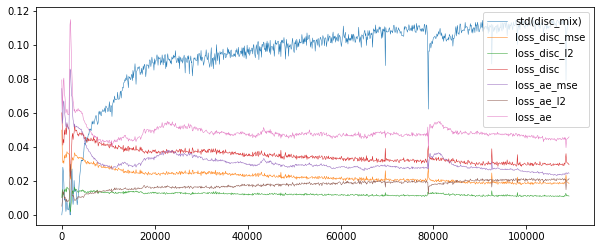

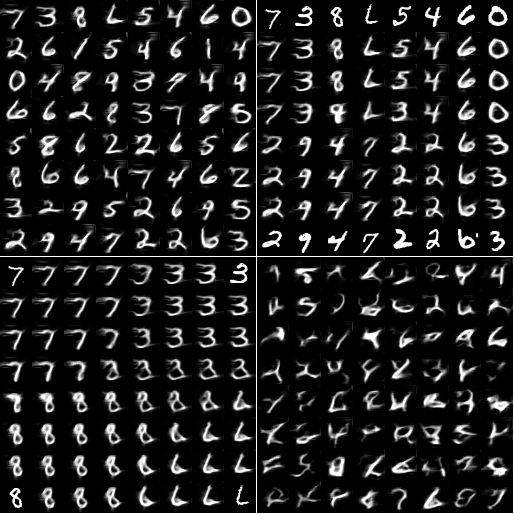

100/100; 1931.20 samples/sec


In [10]:
it = 0
start_time = time.time()

try:
    for epoch in range(args['epochs']):
        for x in x_batches:
            z = encoder(x)
            out = decoder(z)
            disc = discriminator(torch.lerp(out, x, args['reg']))
        
            alpha = torch.rand(args['batch_size'], 1, 1, 1).to(args['device']) / 2
            z_mix = lerp(z, swap_halves(z), alpha)
            out_mix = decoder(z_mix)
            disc_mix = discriminator(out_mix)

            loss_ae_mse = F.mse_loss(out, x)
            loss_ae_l2 = L2(disc_mix) * args['advweight']
            loss_ae = loss_ae_mse + loss_ae_l2
            
            opt_ae.zero_grad()
            loss_ae.backward(retain_graph=True)
            
            
            loss_disc_mse = F.mse_loss(disc_mix, alpha.reshape(-1))
            loss_disc_l2 = L2(disc)
            loss_disc = loss_disc_mse + loss_disc_l2
            
            opt_d.zero_grad()
            loss_disc.backward()
            #RuntimeError inplace
            opt_ae.step()
            opt_d.step()

            losses['std(disc_mix)'].append(torch.std(disc_mix).item())
            losses['loss_disc_mse'].append(loss_disc_mse.item())
            losses['loss_disc_l2'].append(loss_disc_l2.item())
            losses['loss_disc'].append(loss_disc.item())
            losses['loss_ae_mse'].append(loss_ae_mse.item())
            losses['loss_ae_l2'].append(loss_ae_l2.item())
            losses['loss_ae'].append(loss_ae.item())

            if it % 100 == 0:
                img = status()
                
                plt.figure(facecolor='w', figsize=(10,4))
                for key in losses:
                    total = len(losses[key])
                    skip = 1 + (total // 1000)
                    y = build_batches(losses[key], skip).mean(axis=-1)
                    x = np.linspace(0, total, len(y))
                    plt.plot(x, y, label=key, lw=0.5)
                plt.legend(loc='upper right')
                
                clear_output(wait=True)
                plt.show()
                show_array(img * 255)
                
                speed = args['batch_size'] * it / (time.time() - start_time)
                print(f'{epoch+1}/{args["epochs"]}; {speed:.2f} samples/sec')

            it += 1
except KeyboardInterrupt:
    pass

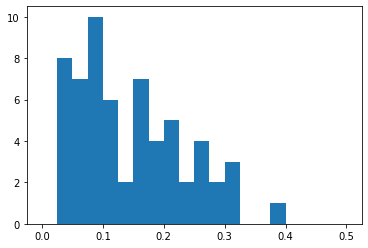

tensor([ 0.2968,  0.0630,  0.1773,  0.1023,  0.1142,  0.0773,  0.1787,  0.0828,
         0.2016,  0.1518,  0.0927,  0.1072,  0.0929,  0.0514,  0.1667,  0.3950,
         0.1079,  0.0448,  0.0838,  0.0471,  0.0853,  0.3047, -0.0059,  0.1059,
         0.0954,  0.2648,  0.2133,  0.1911,  0.3224,  0.2952,  0.0759,  0.1668,
         0.0375,  0.0355,  0.2293,  0.0897,  0.2357,  0.0521,  0.1481,  0.1728,
         0.0490,  0.2665,  0.1382,  0.0467,  0.0373,  0.1500,  0.2242,  0.1962,
         0.2156,  0.2674,  0.1607,  0.0460,  0.0588,  0.2708, -0.0230,  0.1590,
         0.1156,  0.0689,  0.0550,  0.0672,  0.3062, -0.0436,  0.0859,  0.2182],
       device='cuda:0', grad_fn=<MeanBackward1>)


In [11]:
plt.hist(disc_mix.data.cpu().numpy(), range=[0,0.5], bins=20)
plt.show()
print(disc_mix)

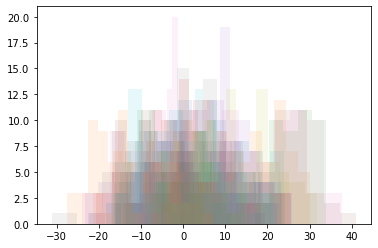

In [12]:
z = encoder(x_batches[0])
z = z.data.cpu().numpy().reshape(len(z), -1).T
for dim in z:
    plt.hist(dim, bins=12, alpha=0.1)
plt.show()